In [1]:
!nvidia-smi

Thu Jan 14 22:38:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !python -m spacy download de_core_news_sm
# !pip install torchtext==0.6.0

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy 
import numpy as np 
import time

In [4]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

In [6]:
SRC = Field(tokenize = tokenize_en,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True, include_lengths=True)

TRG = Field(tokenize=tokenize_de,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)
train_data, valid_data, test_data = Multi30k.splits(exts=('.en', '.de'), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 950kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 272kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 266kB/s]


In [7]:
BATCH_SIZE = 128
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE, device='cuda', sort_within_batch=True, sort_key=lambda x: len(x.src)
)


In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src : [src_len, batch_size]
        #src_len : [batch_size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded : [src_len, batch_size, emb_dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu())
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs : [src_len, batch_size, enc_hid_dim * 2]
        #hidden : [batch_size, dec_hid_dim]
        
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden : [batch_size, dec_hid_dim]
        #encoder_outputs : [src_len, batch_size, enc_hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden : [batch_size, src_len, dec_hid_dim]
        #encoder_outputs : [batch_size, src_len, enc_hid_dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy : [batch_size, src_len, dec_hid_dim]

        attention = self.v(energy).squeeze(2)
        
        #attention : [batch_size, src_len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input : [batch_size]
        #hidden : [batch_size, dec_hid_dim]
        #encoder_outputs : [src_len, batch_size, enc_hid_dim * 2]
        #mask : [batch_size, src_len]
        
        input = input.unsqueeze(0)
        
        #input : [1, batch_size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded : [1, batch_size, emb_dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a : [batch_size, src_len]
        
        a = a.unsqueeze(1)
        
        #a : [batch_size, 1, src_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs : [batch_size, src_len, enc_hid_dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted : [batch_size, 1, enc_hid_dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted : [1, batch_size, enc_hid_dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input : [1, batch_size, (enc_hid_dim * 2) + emb_dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output : [seq_len, batch_size, dec_hid_dim * n directions]
        #hidden : [n_layers * n directions, batch_size, dec_hid_dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output : [1, batch_size, dec_hid_dim]
        #hidden : [1, batch_size, dec_hid_dim]

        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src : [src_len, batch_size]
        #src_len : [batch_size]
        #trg : [trg_len, batch_size]
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch_size, src_len]
                
        for t in range(1, trg_len):
            
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            outputs[t] = output
            
            teacher_force = np.random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

In [10]:
device='cuda'
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [11]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5923, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(7873, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=7873, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [12]:

optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg_len, batch_size]
        #output = [trg_len, batch_size, output_dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg_len - 1) * batch_size]
        #output = [(trg_len - 1) * batch_size, output_dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg_len, batch_size]
            #output = [trg_len, batch_size, output_dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg_len - 1) * batch_size]
            #output = [(trg_len - 1) * batch_size, output_dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 32s
	Train Loss: 5.322 | Train PPL: 204.704
	 Val. Loss: 5.052 |  Val. PPL: 156.298
Epoch: 02 | Time: 0m 32s
	Train Loss: 4.491 | Train PPL:  89.254
	 Val. Loss: 4.825 |  Val. PPL: 124.550
Epoch: 03 | Time: 0m 32s
	Train Loss: 4.140 | Train PPL:  62.813
	 Val. Loss: 4.633 |  Val. PPL: 102.808
Epoch: 04 | Time: 0m 32s
	Train Loss: 3.863 | Train PPL:  47.628
	 Val. Loss: 4.441 |  Val. PPL:  84.875
Epoch: 05 | Time: 0m 32s
	Train Loss: 3.596 | Train PPL:  36.460
	 Val. Loss: 4.221 |  Val. PPL:  68.073
Epoch: 06 | Time: 0m 32s
	Train Loss: 3.286 | Train PPL:  26.733
	 Val. Loss: 3.981 |  Val. PPL:  53.548
Epoch: 07 | Time: 0m 32s
	Train Loss: 3.038 | Train PPL:  20.870
	 Val. Loss: 3.774 |  Val. PPL:  43.565
Epoch: 08 | Time: 0m 32s
	Train Loss: 2.820 | Train PPL:  16.777
	 Val. Loss: 3.638 |  Val. PPL:  38.024
Epoch: 09 | Time: 0m 32s
	Train Loss: 2.563 | Train PPL:  12.973
	 Val. Loss: 3.480 |  Val. PPL:  32.451
Epoch: 10 | Time: 0m 32s
	Train Loss: 2.356 | Train PPL

In [15]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    # src_tensor : [1, len(tokens)]

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)
    # encoder_outputs : [src_len, 1, dec_hid_dim]
    mask = model.create_mask(src_tensor)
    # mask : [1, src_len]
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    # attentions : [max_len,1,len(tokens)]
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [16]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [17]:
example_idx = 12

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['three', 'young', 'children', 'stand', 'around', 'a', 'blue', 'and', 'white', 'barrel', '.']
trg = ['drei', 'kleine', 'kinder', 'stehen', 'um', 'ein', 'blau', '-', 'weißes', 'fass', 'herum', '.']
predicted trg = ['drei', 'kleine', 'kinder', 'stehen', 'um', 'einen', 'blau', '-', 'weißen', 'und', '.', '<eos>']


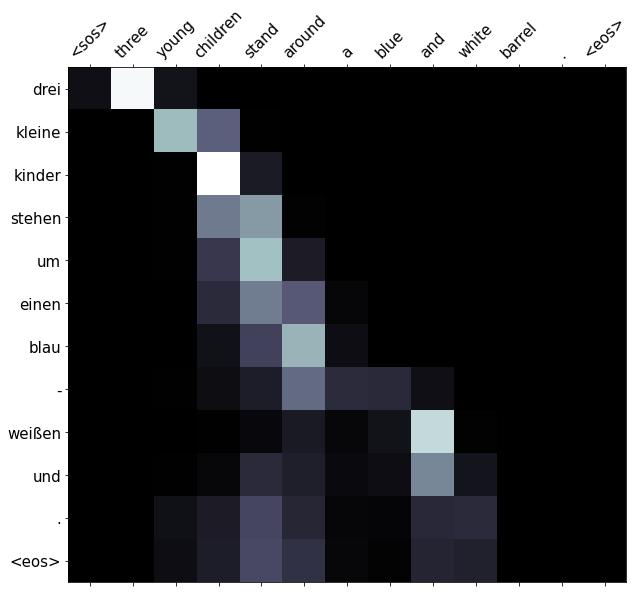

In [18]:
display_attention(src, translation, attention)

In [19]:

def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
  trgs=[]
  pred_trgs=[]

  for d in data:
    src = vars(d)['src']
    trg = vars(d)['trg']

    pred_trg, _ = translate_sentence(src, src_field, trg_field, model, 'cuda')

    pred_trg = pred_trg[:-1]
    pred_trgs.append(pred_trg)
    trgs.append([trg])

  return bleu_score(pred_trgs, trgs)

In [20]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'bleu_score : {bleu_score * 100}')

bleu_score : 26.78120570588986
